In [1]:
%config Completer.use_jedi = False
%config InlineBackend.figure_format='retina'
%matplotlib inline
import ta                                        #pandas-ta library for technical analysis

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt            # plots
import seaborn as sns               # more plots

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from statsmodels import tsa

from itertools import product                    # some useful functions
import datetime as dt
from tqdm.notebook import tqdm
import gc
import os
import re


from sklearnex import patch_sklearn              #sklearn patch for more speed
import platform
if 'intel' in platform.processor().lower():
    patch_sklearn()
from sklearn.linear_model import Ridge, Lasso, LassoCV    #all sklearn imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Let's analyze 8 popular cryptocurrencies of the last years. They are:
- Cardano (ADA)
- Etherium (ETH)
- Litecoin (LTC)
- Bitcoin (XBT)
- Stellar Lumen (XLM)
- Monero (XMR)
- Ripple (XRP)
- Zcash (ZEC)

For this purpose we will download the latest OHLCVT data from the Kraken exchange website
https://support.kraken.com/hc/en-us/articles/360047124832-Downloadable-historical-OHLCVT-Open-High-Low-Close-Volume-Trades-data
The data comes in different periodicity of one day, 12-hour, 1-hour, 15 minutes, 5 minutes, 1 minute.

In [2]:
dfs = []
windows = [1, 5, 15, 60, 720, 1440]
cols = ['open', 'high', 'low', 'close', 'volume', 'trades']

for crypto_dir in os.listdir('./data'):
    if os.path.isdir('./data/' + crypto_dir):
        crypto_name = re.match('^([A-Z]+)_OHLCVT$', crypto_dir).group(1)
        df = pd.read_csv(f'data/{crypto_dir}/{crypto_name}USD_{windows[5]}.csv', names=cols, index_col=0)
        df.index = pd.to_datetime(df.index, unit = 's')
        df.name = crypto_name
        dfs.append(df)

Then we will analyze close data for all cryptocurrencies at hand. For this purpose we will use one day data and should  determine the minimum date since which we will have information for all of them. Also, the data should be standardized. The graph shows high correlation between different cryptocurrencies price values. But we are not intrested in simple correlation, we need to know which one has the most impact on others.

In [3]:
# plt.style.use('ggplot') 

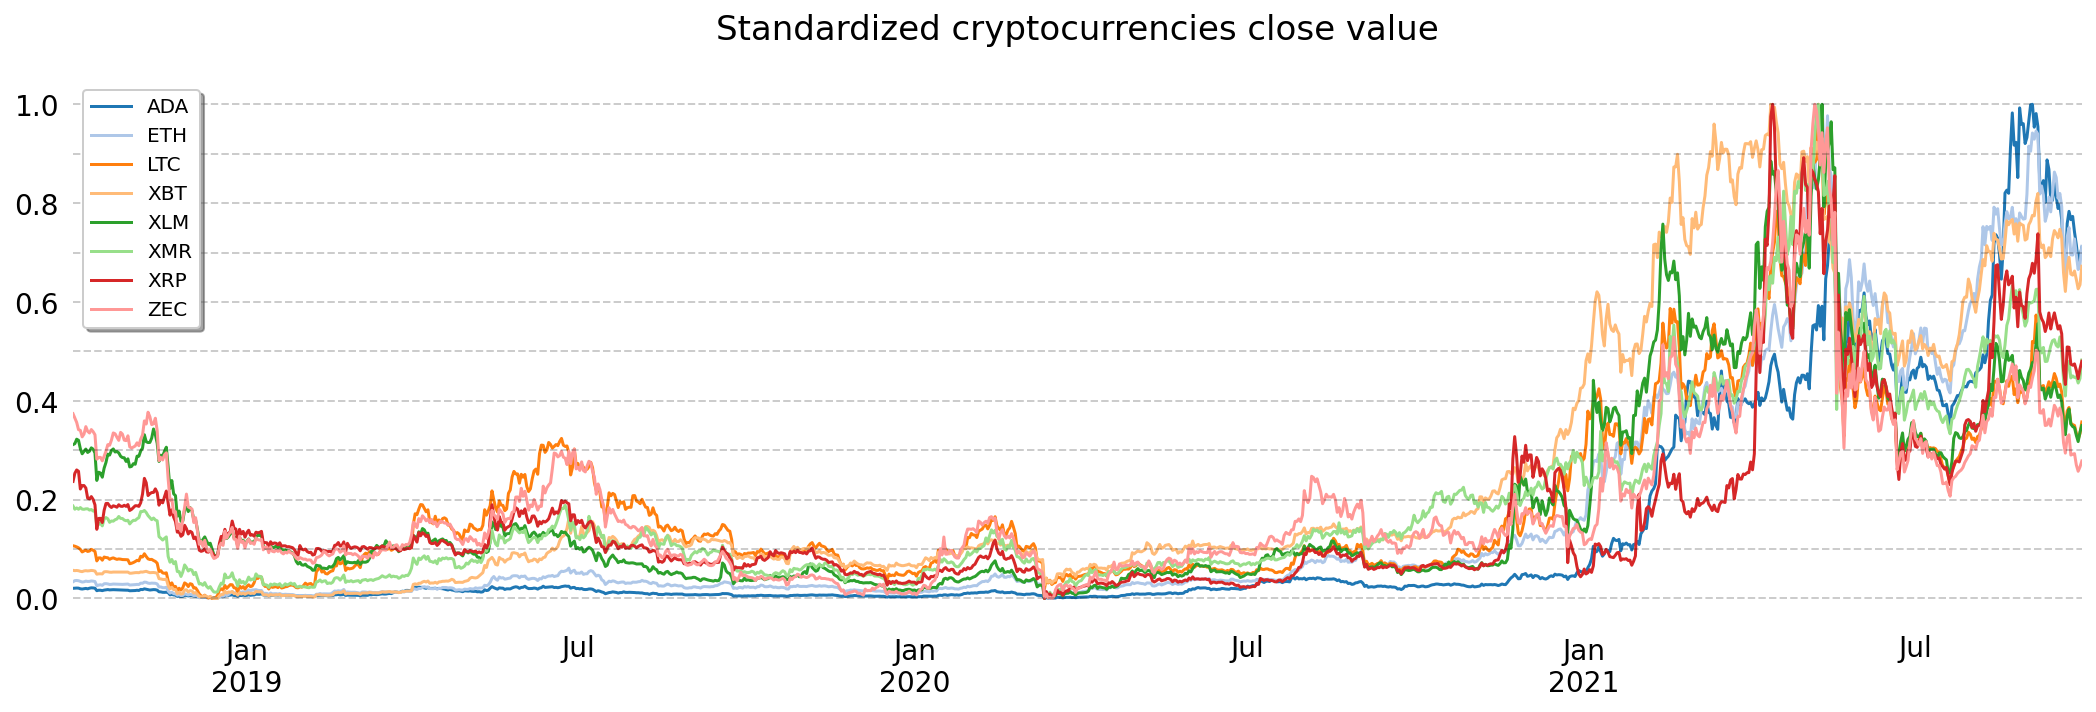

In [4]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)] 
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)
plt.figure(figsize=(18, 5))
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left() 

plt.tick_params(axis="both", which="both", bottom=False, left=False, labelsize=14)
min_date = dfs[0].index[0]
for df in dfs[1:]:
    if df.index[0] > min_date:
        min_date = df.index[0]
        
        
for rank, df in enumerate(dfs):
    data = df.loc[min_date:, 'close']
    ((data - data.min()) / (data.max() - data.min())).plot(label=df.name, color=tableau20[rank])
for y in np.arange(0, 1.1, 0.1):    
    plt.axhline(y, color='black', linestyle='--', lw=1, alpha=0.2)
plt.legend(shadow=True, fancybox=True);
title = 'Standardized cryptocurrencies close value'
plt.title(title, fontsize=17, ha='center', pad=20)
plt.savefig(f'{title}.png', bbox_inches='tight');

For this we will use time-lag crosscorelation. We will use lag values in range of 1 to 20 with the mean value taken for each cryptocurrency.

In [5]:
for idx_1 in range(len(dfs)):
    sum_corrs = []
    for lag in range(-20, 0):
        sum_corr = 0
        for idx_2 in range(len(dfs)):
            sum_corr += dfs[idx_1].loc[min_date:, 'close'].corr(dfs[idx_2].loc[min_date:, 'close'].shift(lag))
        sum_corrs.append(sum_corr - 1)
    print(dfs[idx_1].name, ': ', np.mean(sum_corrs))

ADA :  5.571945151806862
ETH :  5.948151847189147
LTC :  5.827865523290746
XBT :  6.119069490293652
XLM :  5.8575955570468565
XMR :  6.128007381008224
XRP :  5.466901055048788
ZEC :  5.518148460146095


Suprisingly, the Monero has larger impact on other coins than Bitcoin, although the latter is pretty close and on the second place. Thus, we will use Monero for further analysis, particularly the more precise 1-minute data.

Brief history and technical information

Monero was launched in April 2014. It was a fair, pre-announced launch of the CryptoNote reference code. There was no premine or instamine, and no portion of the block reward goes to development. The founder, thankful_for_today, proposed some controversial changes that the community disagreed with. A fallout ensued, and the Monero Core Team forked the project with the community following new Core Team. This Core Team has provided oversight since.

Monero has made several large improvements since launch. The blockchain was migrated to a different database structure to provide greater efficiency and flexibility, minimum ring signature sizes were set so that all transactions were private by mandate, and RingCT was implemented to hide the transaction amounts. 

Monero uses randomx, an ASIC-resistant and CPU-friendly POW algorithm created by Monero community members, designed to make the use of mining-specific hardware unfeasible. Monero previously used CryptoNight and variations of this algorithm.

To make sure there will always be an incentive to mine Monero and keep it safe, the emission is infinite. There are two main emissions: first, main curve: ~18.132 million coins by the end of May 2022, then, tail curve: 0.6 XMR per 2-minute block, kicks in once main emission is done, translates to <1% inflation decreasing over time (Tail Emission).

A new block is created every ~2 minutes. There is no maximum block size, but instead a block reward penalty and a dynamic block size, to ensure a dynamic scalability.

In [28]:
df = pd.read_csv('data/XMR_OHLCVT/XMRUSD_1440.csv', names=cols, index_col=0)
df.index = pd.to_datetime(df.index, unit = 's')
df.head()

,open,high,low,close,volume,trades
2017-01-02,19.13000,19.49000,15.50010,16.79499,3081.991438,145
2017-01-03,16.00000,17.98900,15.00000,15.95220,6799.851072,368
2017-01-04,16.11099,18.48870,16.00004,18.48385,2970.640066,188
2017-01-05,18.38552,18.72991,13.00000,16.19979,7059.115509,447
2017-01-06,16.19980,16.72785,13.50000,14.13538,3570.718028,216


No let's do some basic EDA.

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1732 entries, 2017-01-02 to 2021-09-30
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1732 non-null   float64
 1   high    1732 non-null   float64
 2   low     1732 non-null   float64
 3   close   1732 non-null   float64
 4   volume  1732 non-null   float64
 5   trades  1732 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 94.7 KB


In [7]:
df.describe()

,open,high,low,close,volume,trades
count,1732.000000,1732.000000,1732.000000,1732.000000,1732.000000,1732.000000
mean,121.567865,127.452739,115.558830,121.903224,8036.437798,1698.799654
std,92.764531,98.398440,86.621797,92.909143,8483.798529,1911.892609
min,0.010000,11.000100,0.010000,10.660030,92.231144,7.000000
25%,55.230000,57.452500,53.175000,55.436935,3146.752944,574.750000
50%,89.875000,93.390000,86.500000,89.930000,5622.701225,1062.500000
75%,159.087500,167.882500,153.260000,159.597500,9920.165573,2146.250000
max,482.910000,517.600000,452.580000,484.440000,85917.964165,20823.000000


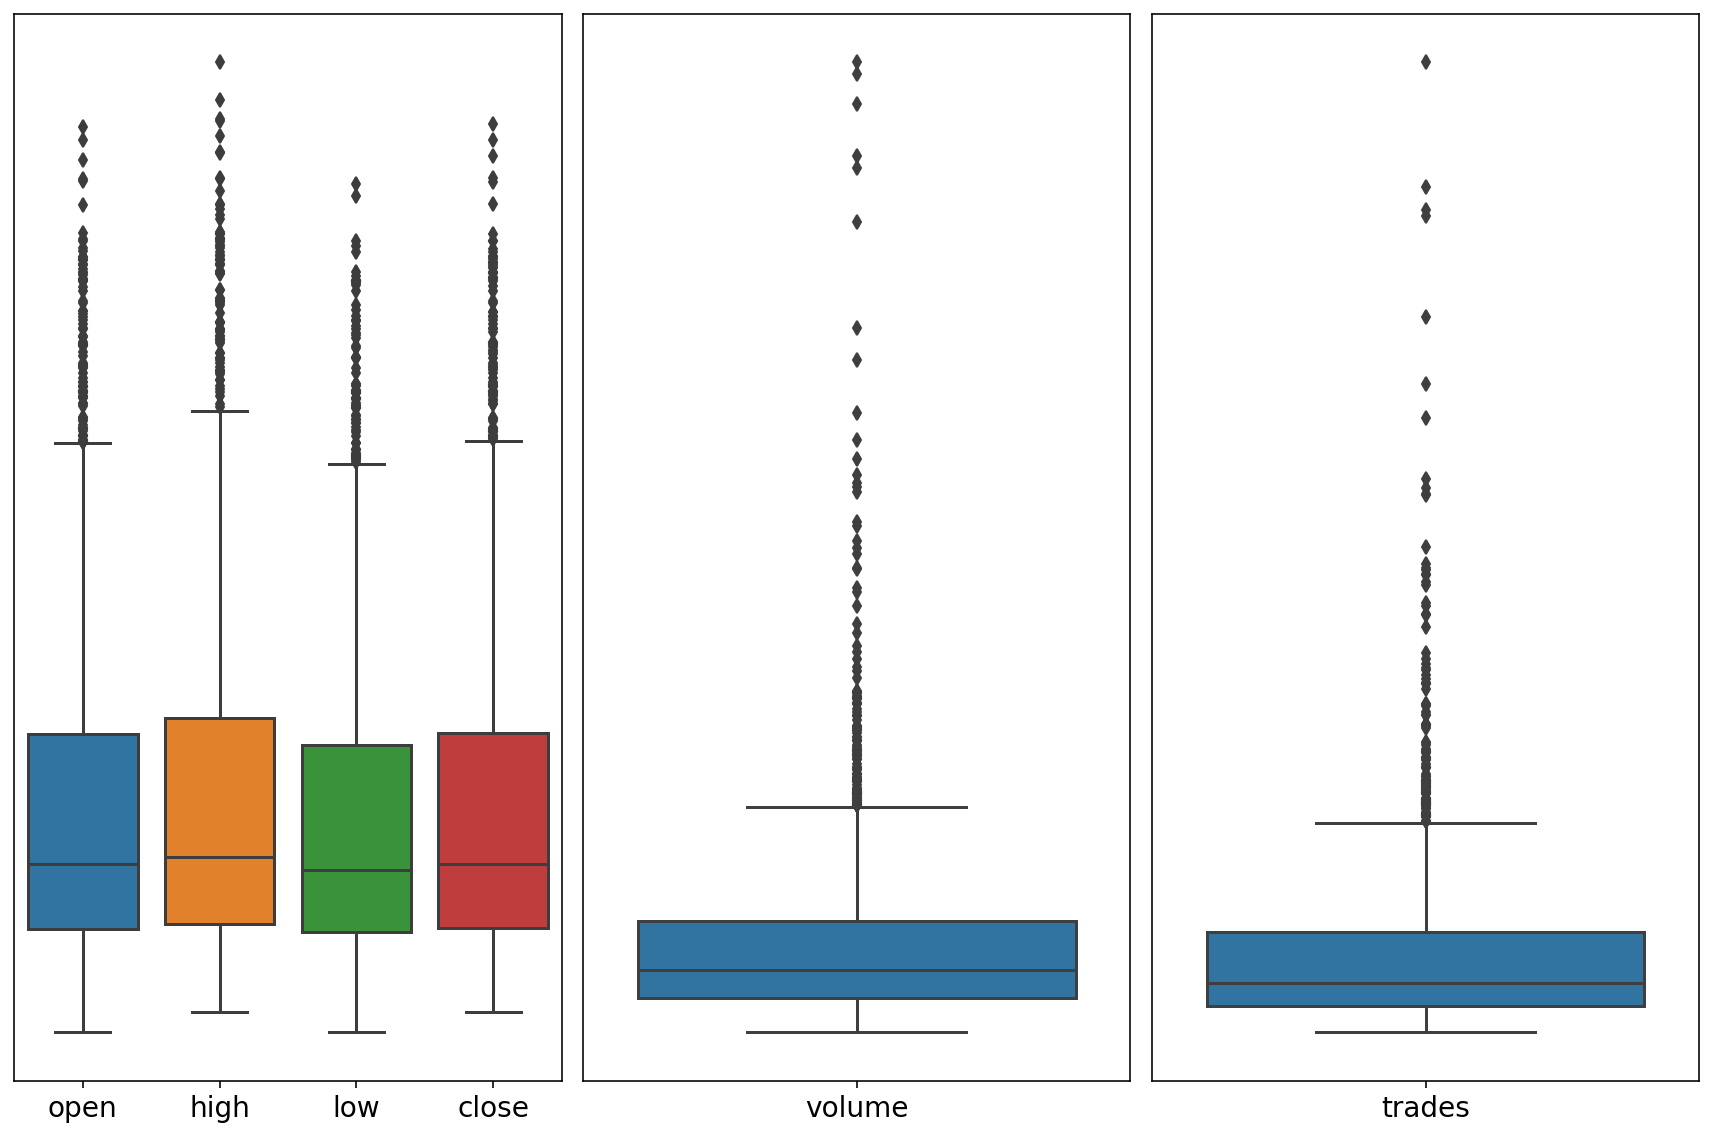

In [8]:
fig, ax = plt.subplots(1,3, figsize=(12, 8))
sns.boxplot(data=df[['open', 'high', 'low', 'close']], ax=ax[0])
sns.boxplot(data=df[['volume']], ax=ax[1])
sns.boxplot(data=df[['trades']], ax=ax[2]);
for i in range(3):
    ax[i].tick_params(axis = 'both', which = 'both',labelleft=False, left=False, labelsize = 14)
plt.tight_layout()
plt.savefig('eda.png', bbox_inches='tight');

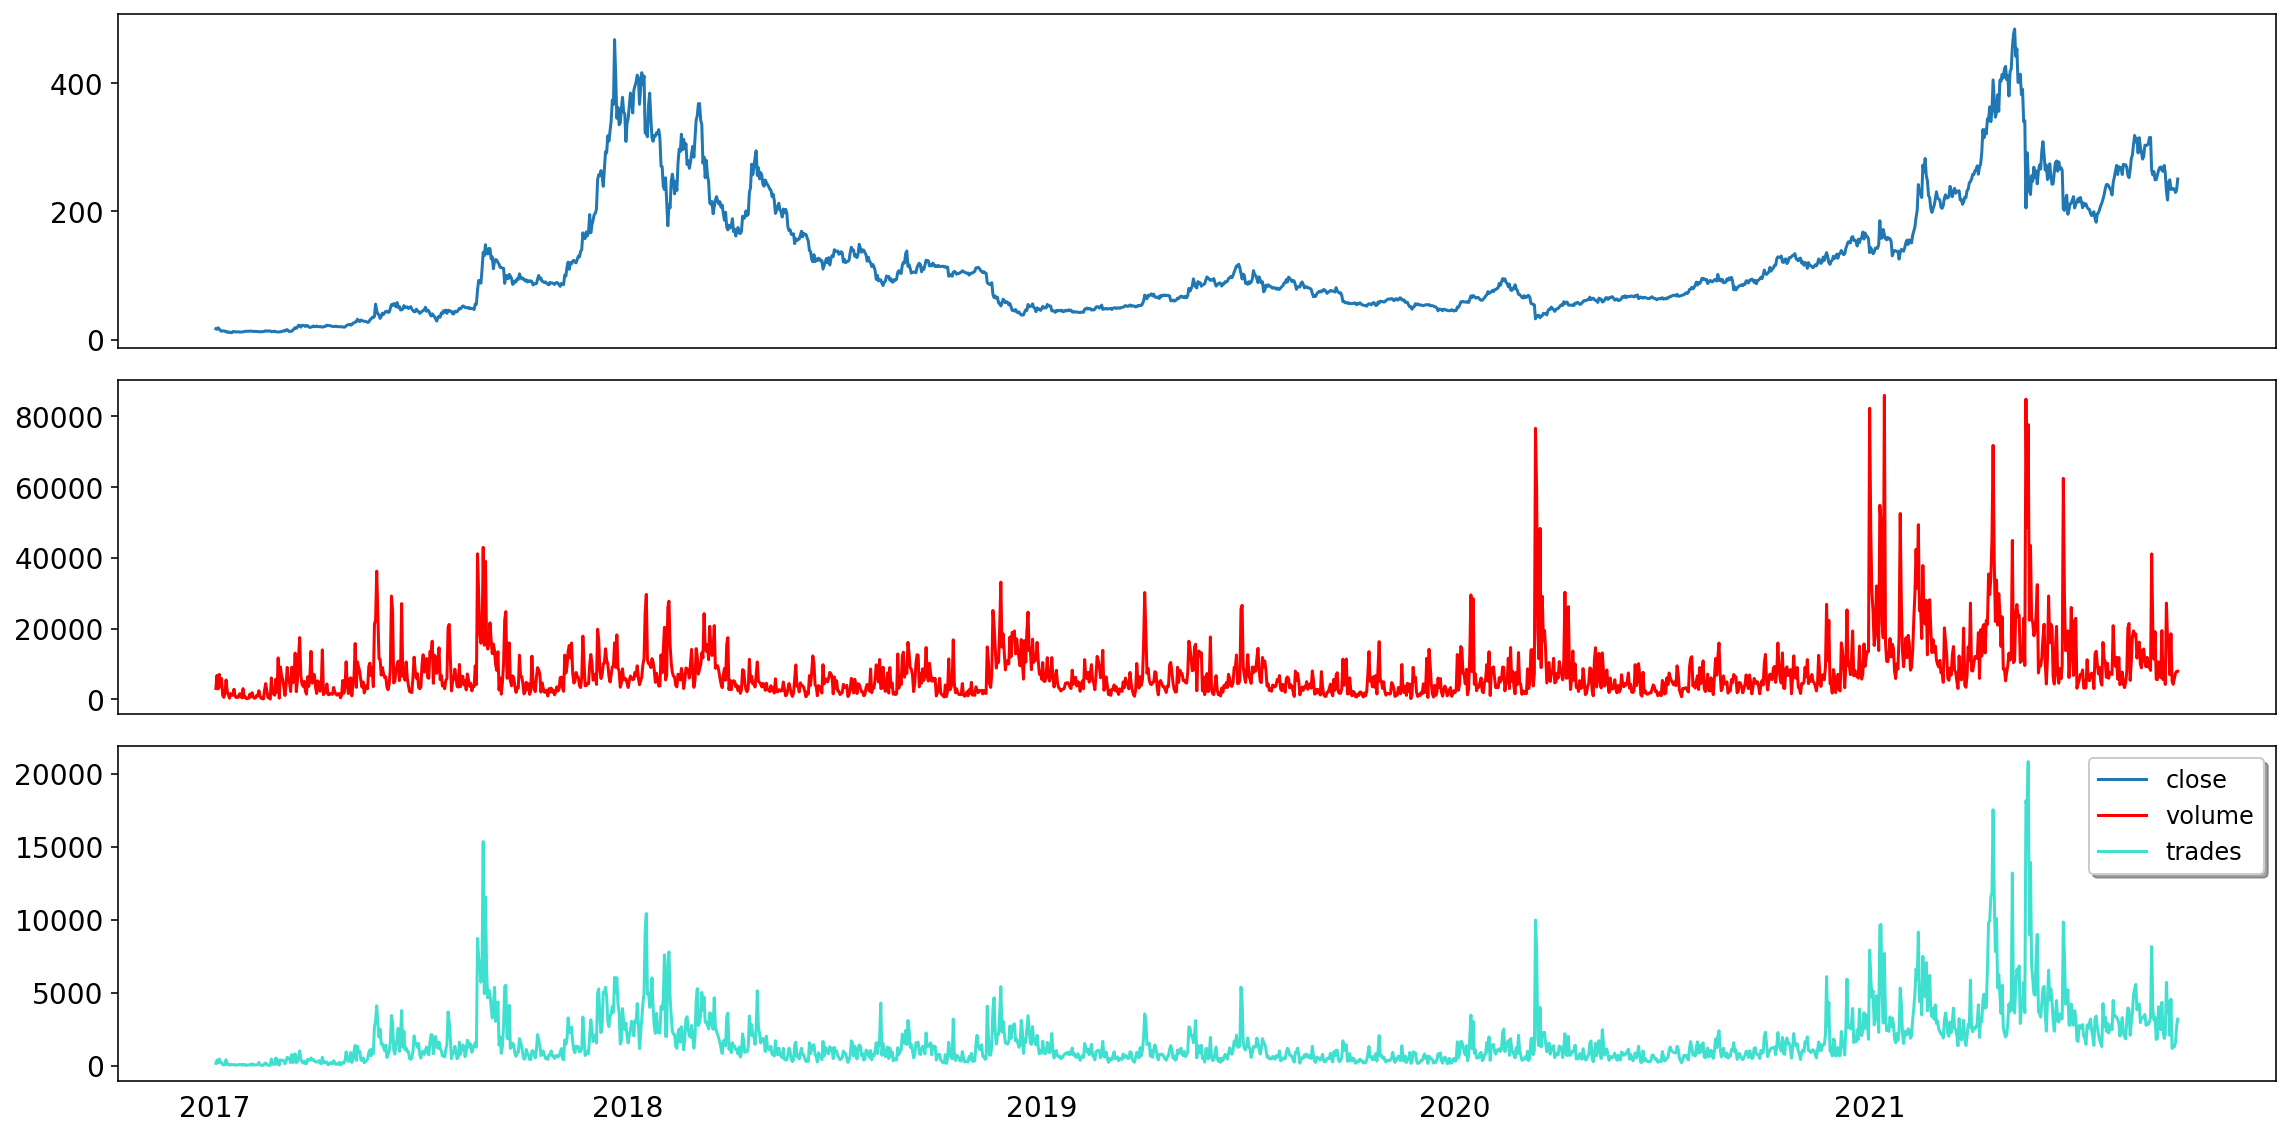

In [9]:
fig, ax = plt.subplots(3, 1, figsize=(16, 8), sharex=True)
l1, = ax[0].plot(df.index, df.close, label = 'close')
l2, = ax[1].plot(df.index, df.volume, color='r', label='volume')
l3, = ax[2].plot(df.index, df.trades, color='turquoise', label='trades')   
plt.legend(handles=[l1, l2, l3], shadow=True, fancybox=True, fontsize='large')
for i in range(3):
    ax[i].tick_params(axis = 'both', which = 'both', bottom=False, labelsize = 14)
plt.tight_layout();
plt.savefig('eda2.png', bbox_inches='tight');

In [10]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])


def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False, plot_actual=True):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(18,5))
    ax = plt.gca()    
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)
    plt.title(f'{series.columns[0].capitalize()}\n moving average window size = {window}')
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=6, label="Anomalies")
    if plot_actual:
        plt.plot(series[window:], label="Actual values")
    ax.tick_params(axis = 'both', which = 'both', bottom=False, left=False, labelsize = 14)
    plt.legend(loc="upper left", shadow=True, fancybox=True)
    plt.grid(True, axis='y', alpha=0.3)
    plt.savefig('eda3.png', bbox_inches='tight');

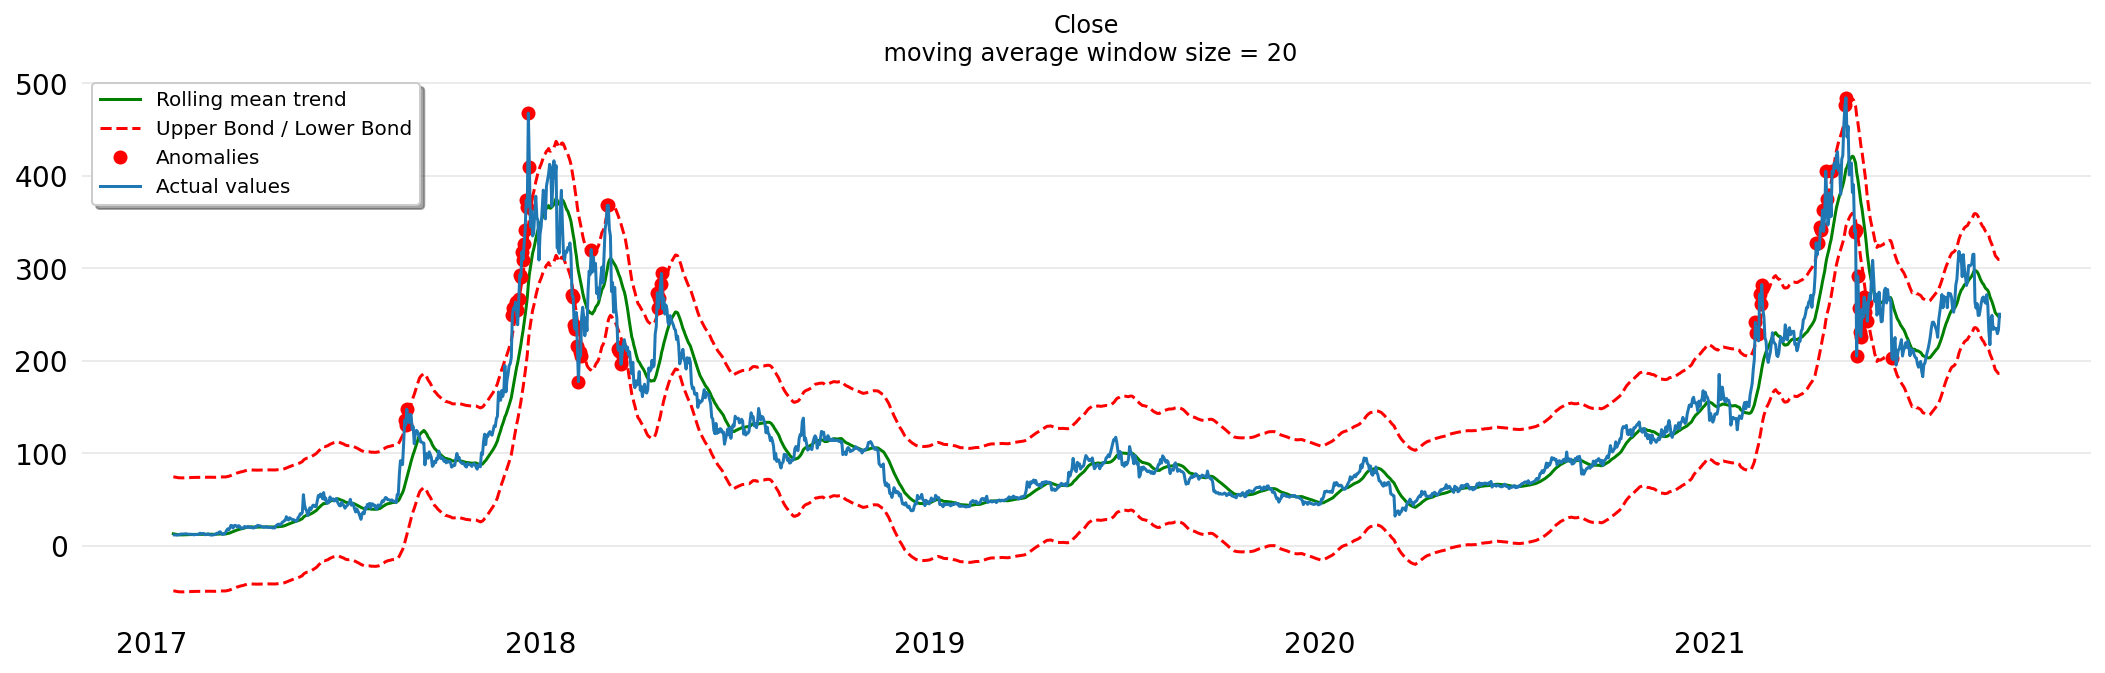

In [11]:
plotMovingAverage(df[['close']], 20, plot_intervals=True, plot_anomalies=True)

In [12]:
df = pd.read_csv('data/XMR_OHLCVT/XMRUSD_1440.csv', names=cols, index_col=0)
df.index = pd.to_datetime(df.index, unit = 's')
ta_df = ta.add_all_ta_features(df, 'open', 'high', 'low', 'close', 'volume', fillna=True)

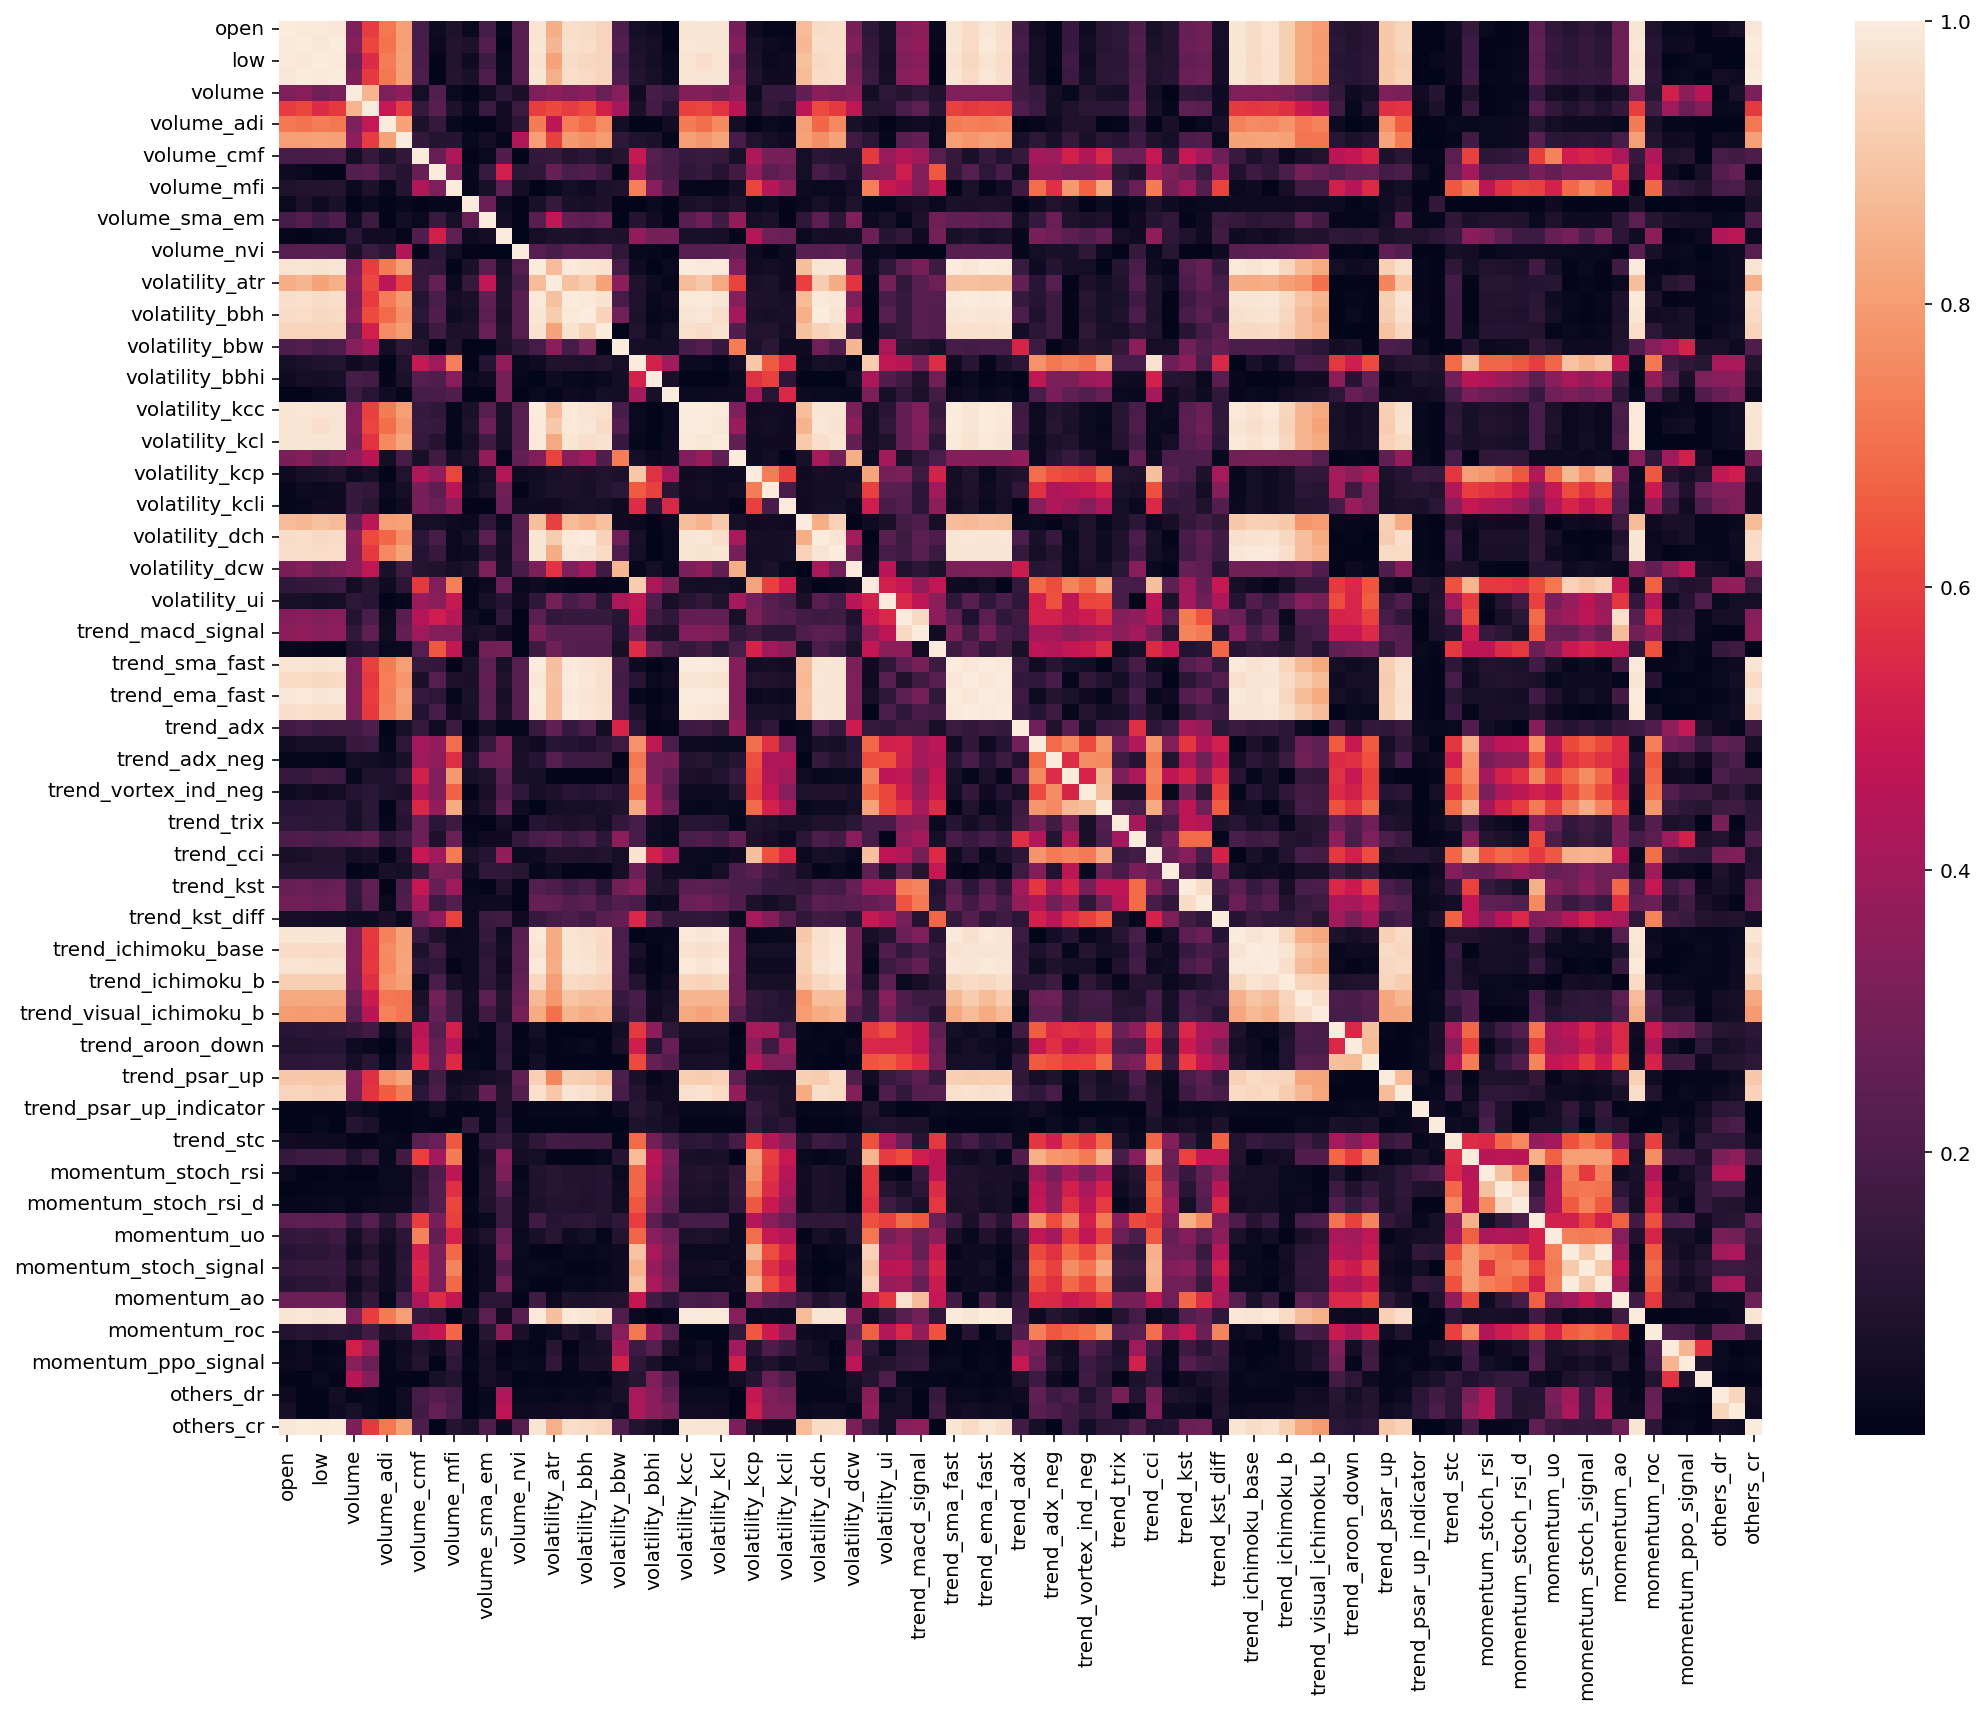

In [13]:
plt.figure(figsize=(15, 12))
sns.heatmap(ta_df.corr().abs())
plt.tight_layout()
plt.savefig('corr1.png', bbox_inches='tight');

In [14]:
cor_matrix = ta_df.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.98)]
clear_df = ta_df.drop(to_drop, axis=1)

In [15]:
clear_df.columns
clear_df.rename(columns={'open':'close'}, inplace=True)
clear_df.close = ta_df.close

In [16]:
clear_df.drop([
 'volatility_bbl',
 'volatility_bbw',
 'volatility_bbp',
 'volatility_bbhi',
 'volatility_bbli',
 'volatility_kcw',
 'volatility_kcp',
 'volatility_kchi',
 'volatility_kcli',
 'volatility_dcl',
 'volatility_dcw',
 'volatility_dcp',
 'trend_ichimoku_b',
 'trend_psar_up',
 'trend_psar_down',
 'trend_psar_up_indicator',
 'trend_psar_down_indicator'], axis=1, inplace=True)

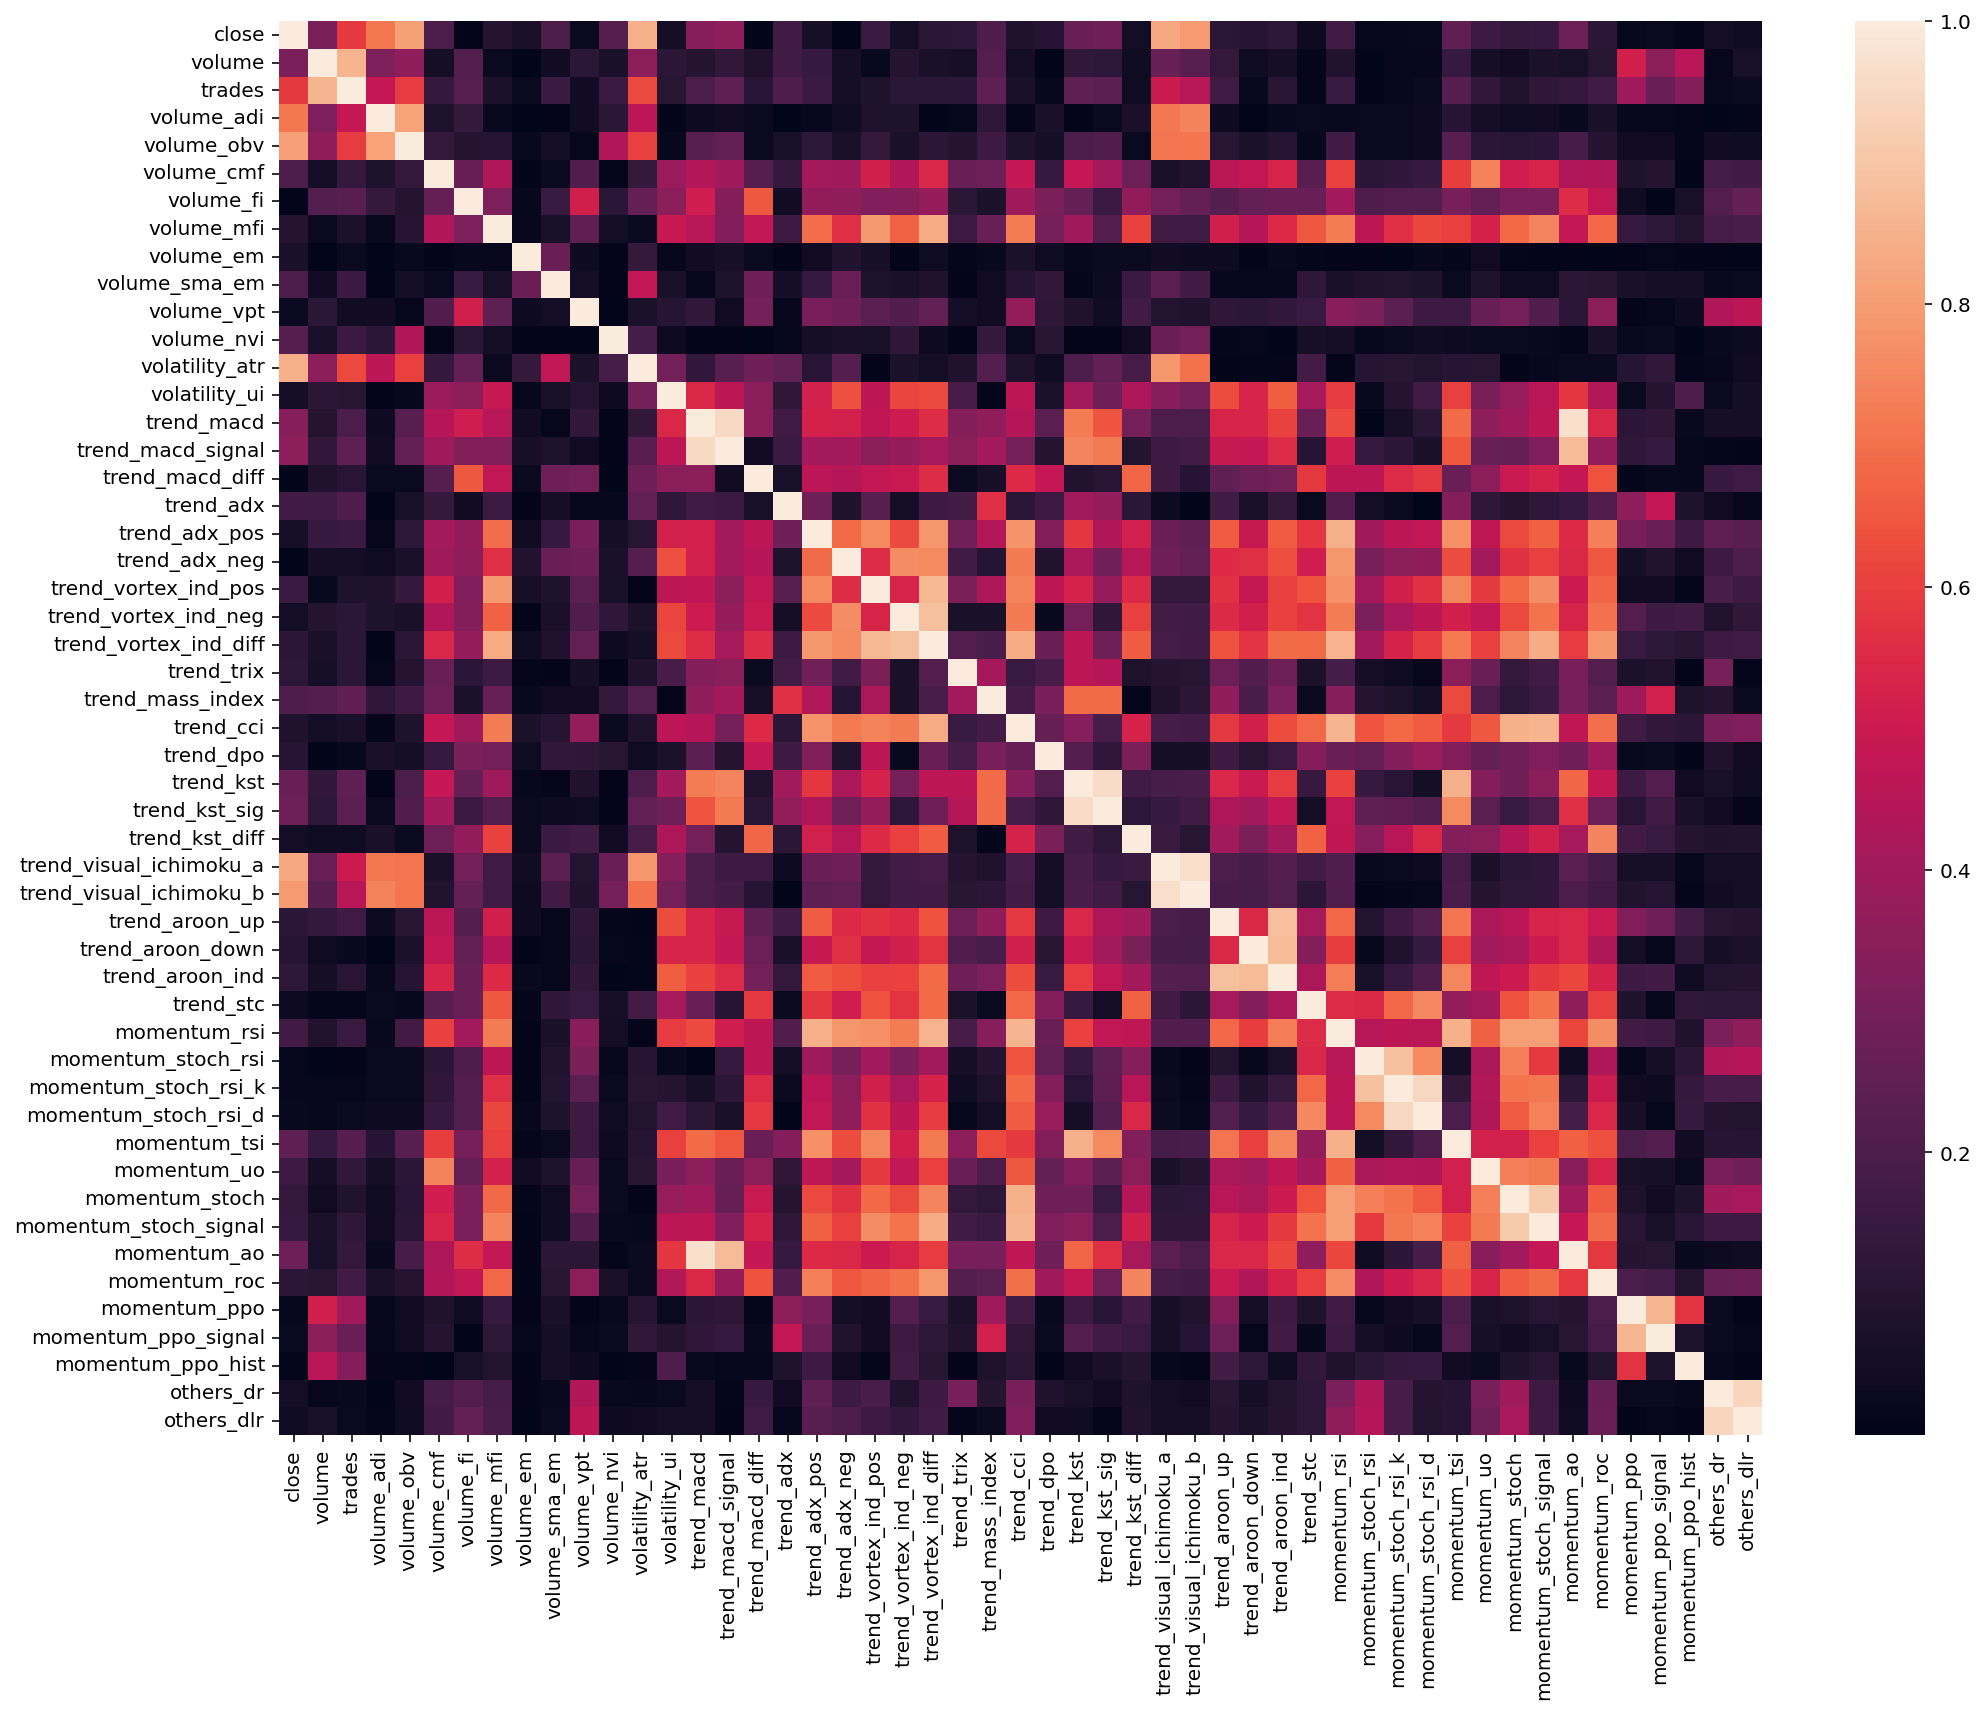

In [17]:
plt.figure(figsize=(15, 12))
sns.heatmap(clear_df.corr().abs())
plt.tight_layout()
plt.savefig('corr2.png', bbox_inches='tight');

In [18]:
def build_window(df, size):
    new_cols = []
    y = []
    for i in range(size):
        new_cols += list(df.columns + f'_lag{size-i}')
        
    
    
    new_df = pd.DataFrame(np.zeros((df.shape[0] - size, df.shape[1] * size)),columns=new_cols, index=df.index[size:])
    for i in range(size, df.shape[0]):
        new_df.iloc[i-size, :] = df.iloc[i-size:i, :].values.flatten()
    new_df['close'] = df.iloc[size:, 0]
    return new_df

In [19]:
def solve(df, sizes):
    cols = ['R2', 'MAE', 'MedAE', 'MSE', 'MSLE', 'MAPE'] 
    result = {'Random Forest': pd.DataFrame(index=sizes, columns=cols), 
              'Lasso': pd.DataFrame(index=sizes, columns=cols),
              'XGBoost': pd.DataFrame(index=sizes, columns=cols)}
    
    for size in tqdm(sizes):
        lag_df = build_window(df, size)
        
        
        X = lag_df.drop('close', axis=1)
        y = lag_df['close']
        idx = 1300
        X_tr, X_te = X.iloc[:idx, :], X.iloc[idx:, :]
        y_tr, y_te = y.iloc[:idx], y.iloc[idx:]

        scaler = StandardScaler()
        X_tr_scaled = scaler.fit_transform(X_tr)
        
        lasso = Lasso()
        lasso.fit(X_tr_scaled, y_tr)
        X_tr_filtered = X_tr[X_tr.columns[abs(lasso.coef_) > 1e-5]]
        X_te_filtered = X_te[X_te.columns[abs(lasso.coef_) > 1e-5]]
        X_tr_filtered_scaled = scaler.fit_transform(X_tr_filtered)
        X_te_filtered_scaled = scaler.transform(X_te_filtered)
        
        models = {'Random Forest': RandomForestRegressor(n_estimators=100 - int(size*1.5), max_depth=10 - size//10), 
                  'Lasso': Lasso(alpha=1 + 1 / 40 * size),
                  'XGBoost': XGBRegressor(n_estimators=100 - int(size*1.5), max_depth=10 - size//10)}
        
        for model_name, model in models.items():
            model.fit(X_tr_filtered_scaled, y_tr)
            result[model_name].loc[size, 'R2'] = r2_score(model.predict(X_te_filtered_scaled), y_te)
            result[model_name].loc[size, 'MAE'] = mean_absolute_error(model.predict(X_te_filtered_scaled), y_te)
            result[model_name].loc[size, 'MedAE'] = median_absolute_error(model.predict(X_te_filtered_scaled), y_te)
            result[model_name].loc[size, 'MSE'] = mean_squared_error(model.predict(X_te_filtered_scaled), y_te)
            result[model_name].loc[size, 'MSLE'] = mean_squared_log_error(abs(model.predict(X_te_filtered_scaled)), y_te)
            result[model_name].loc[size, 'MAPE'] = mean_absolute_percentage_error(model.predict(X_te_filtered_scaled), y_te)
    return result

In [20]:
res = solve(clear_df, range(1, 60))

  0%|          | 0/59 [00:00<?, ?it/s]

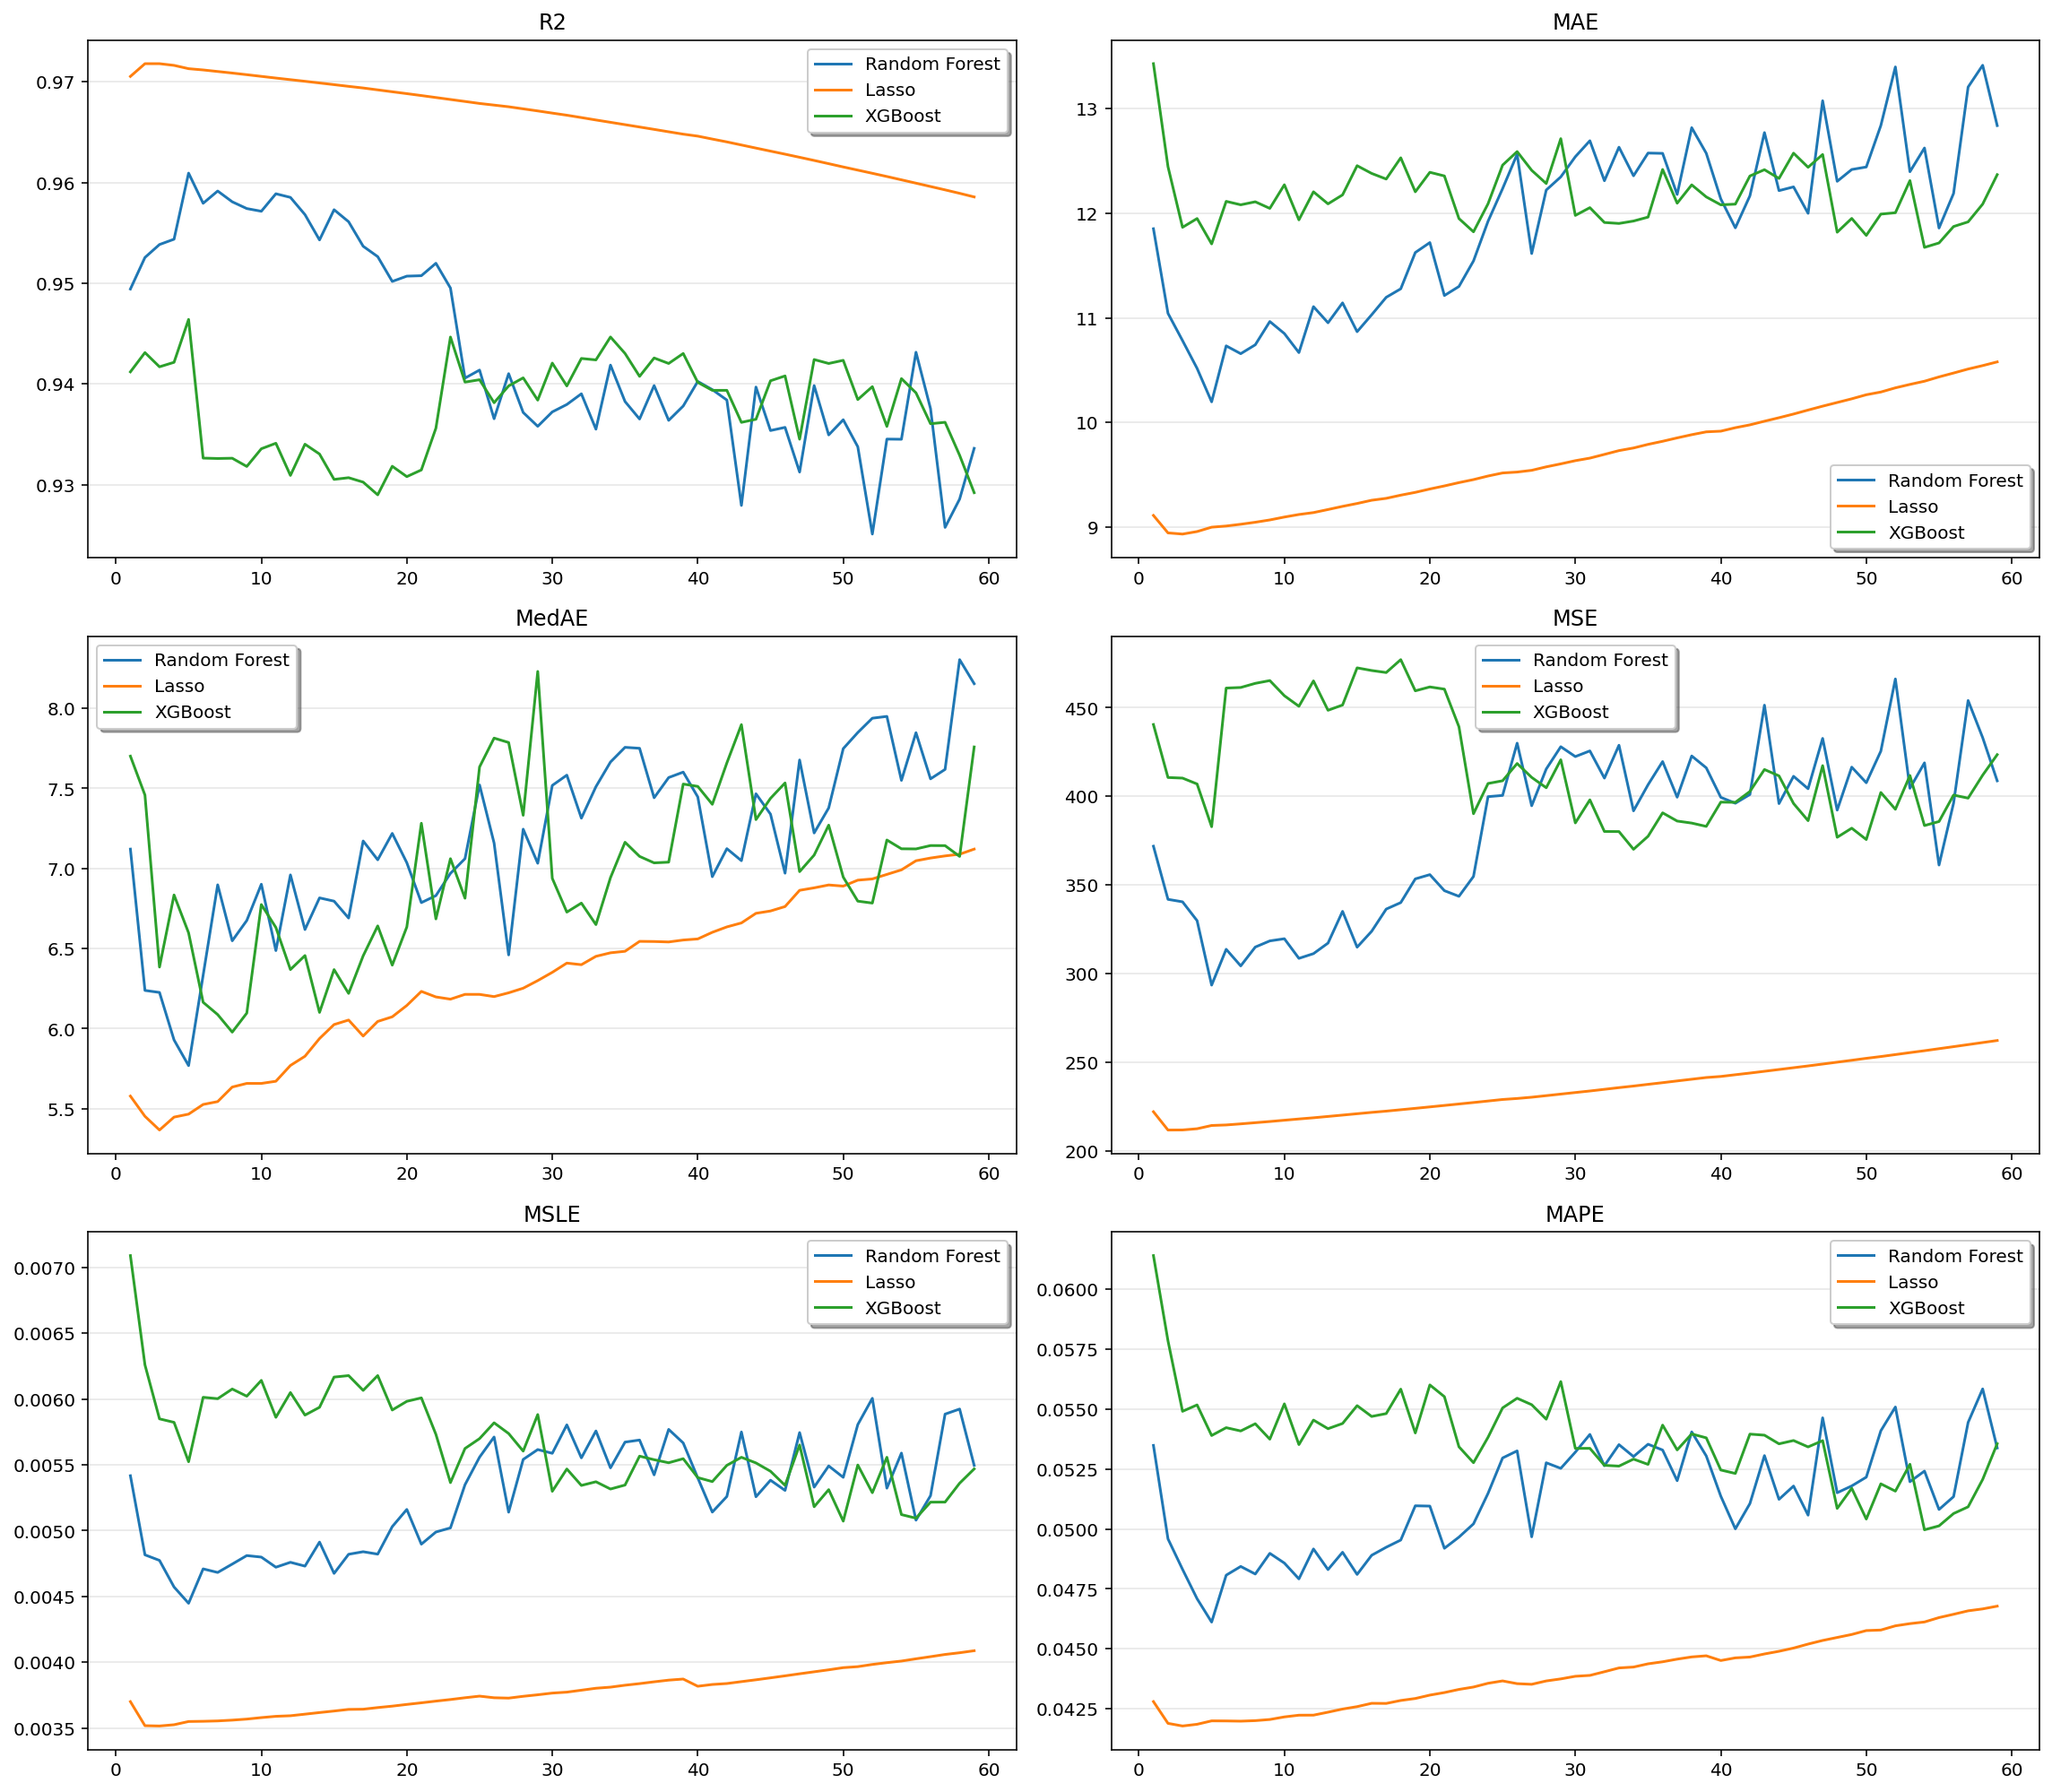

In [24]:
fig, ax = plt.subplots(3, 2, figsize=(16,14))
for i, metric in enumerate(['R2', 'MAE', 'MedAE', 'MSE', 'MSLE', 'MAPE']):
    for k,v in res.items():
        ax[i//2, i%2].plot(v[metric], label=k)
        ax[i//2, i%2].set_title(metric)
        ax[i//2, i%2].grid(True, axis='y', alpha=0.3)
        ax[i//2, i%2].legend(fancybox=True, shadow=True)
plt.tight_layout();
plt.savefig('window_res1.png', bbox_inches='tight');

In [25]:
res = solve(clear_df, range(1, 10))

  0%|          | 0/9 [00:00<?, ?it/s]

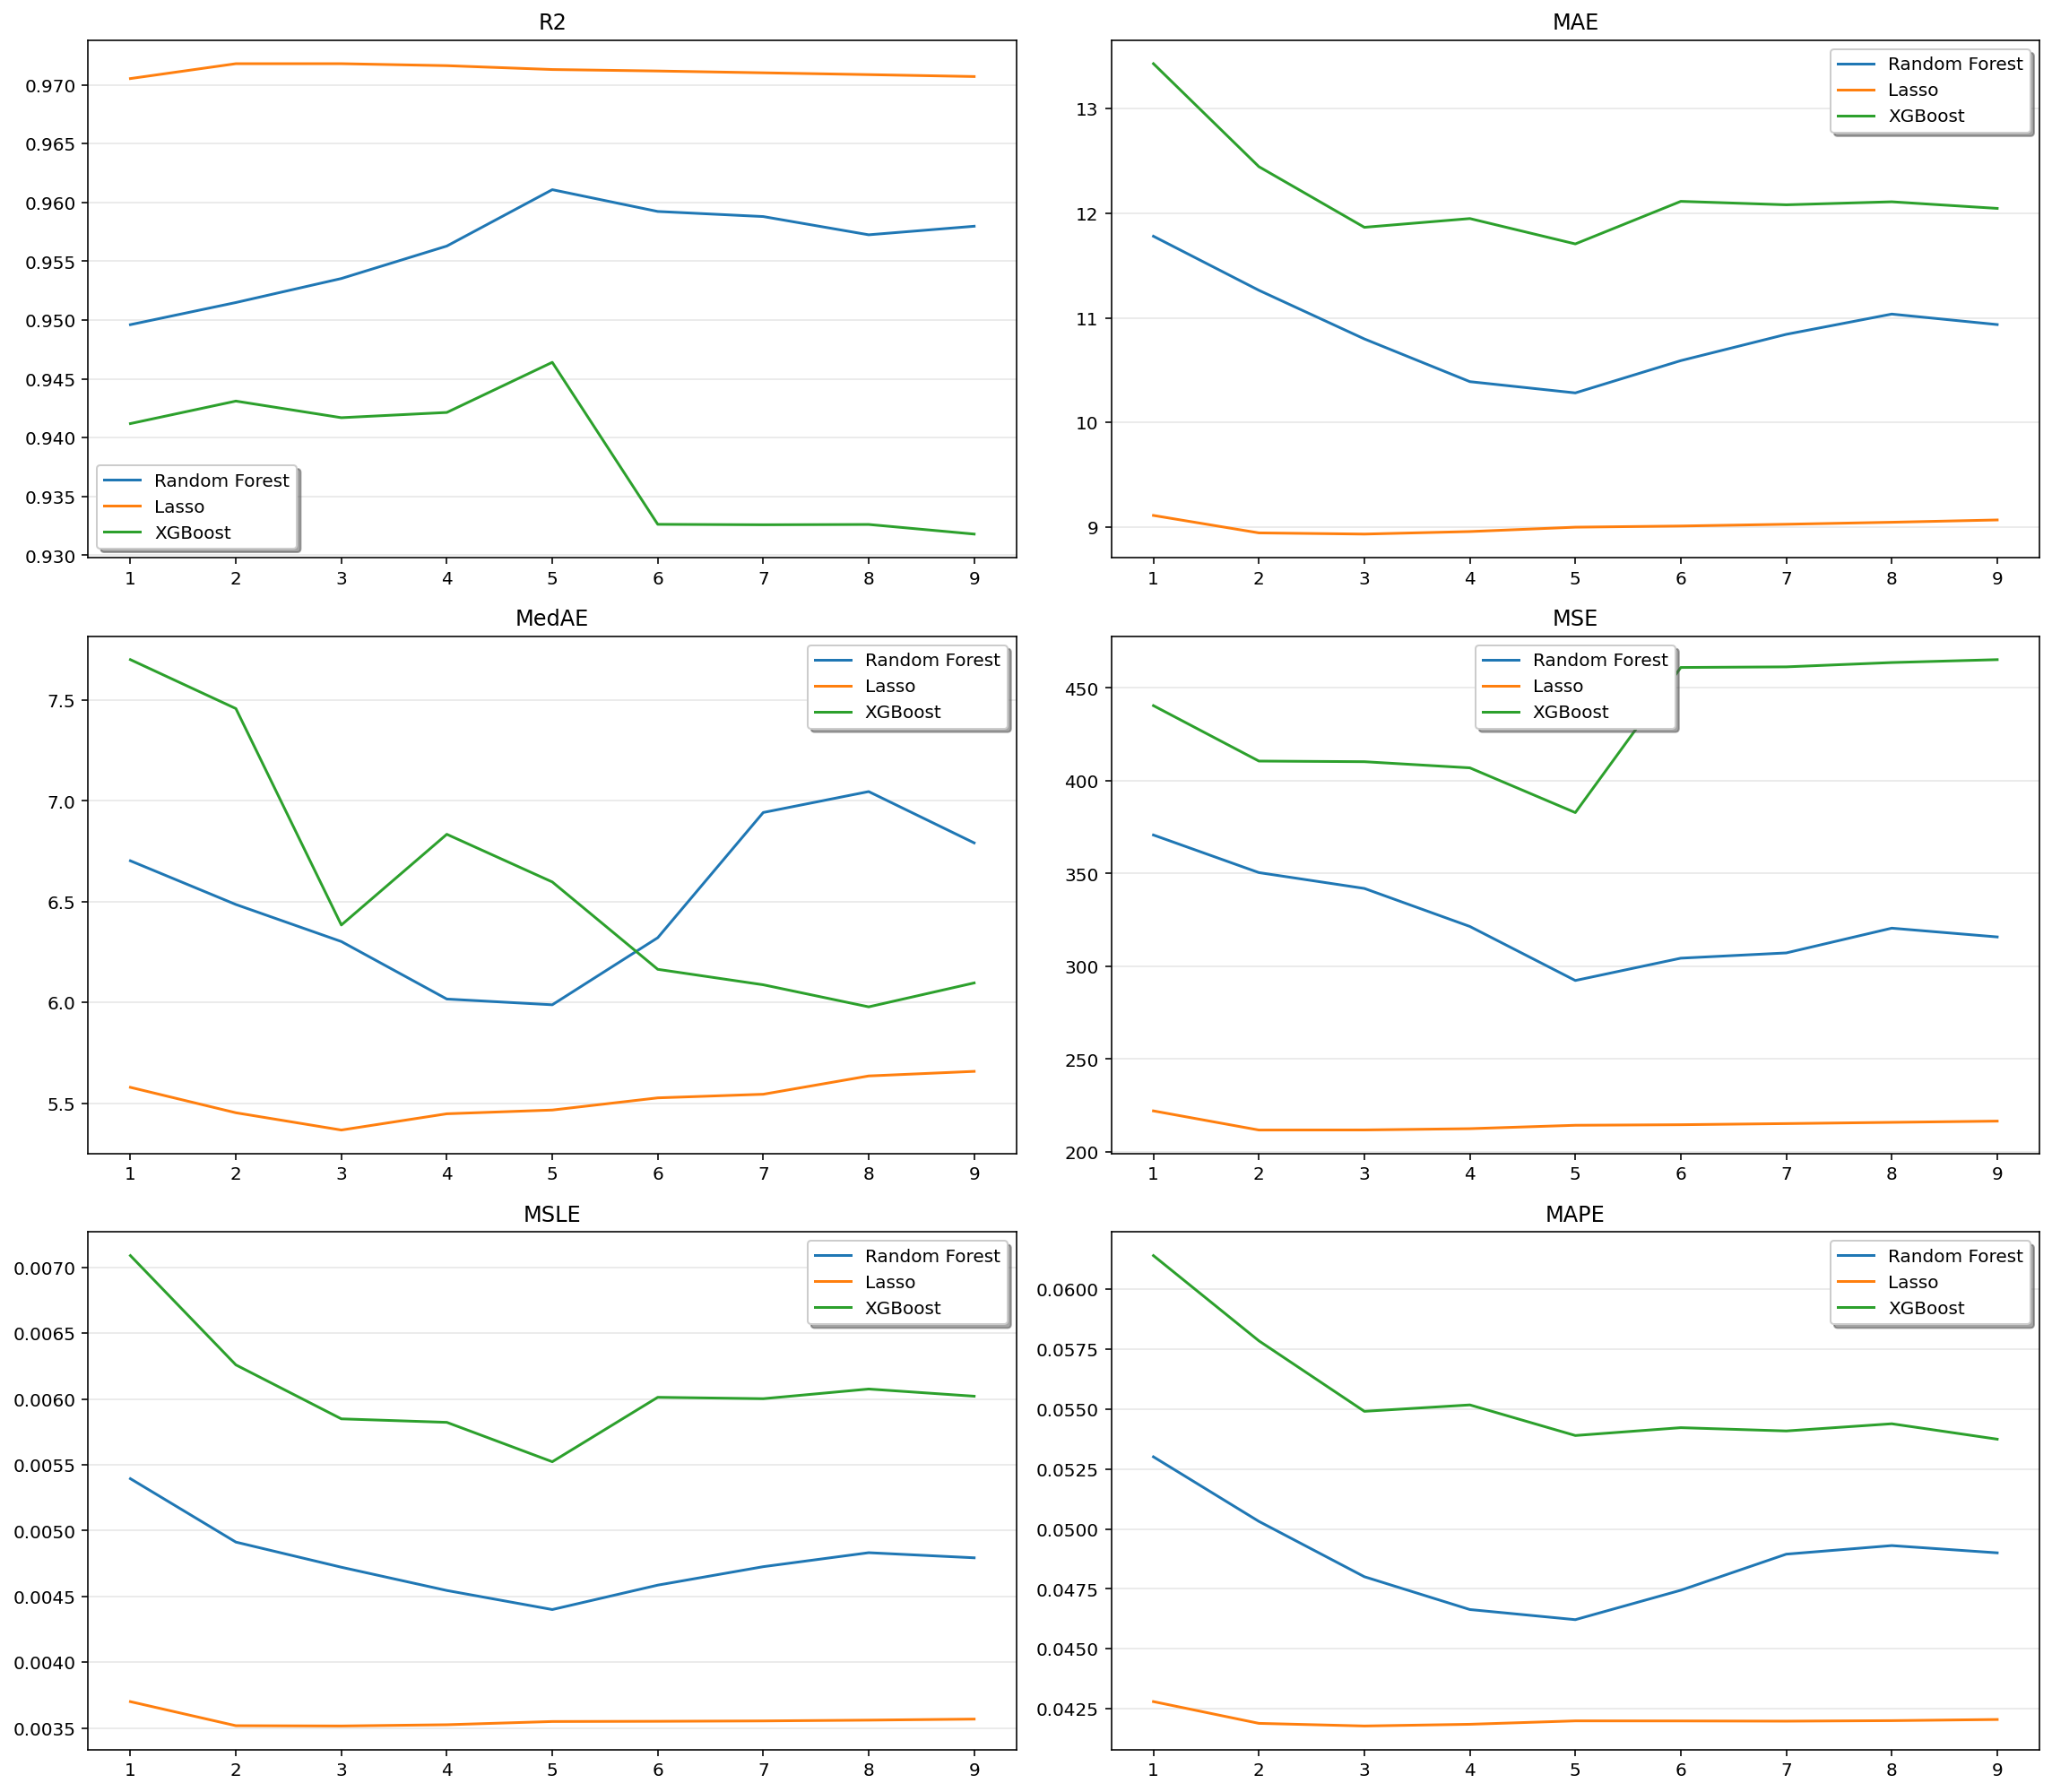

In [26]:
fig, ax = plt.subplots(3, 2, figsize=(16,14))
for i, metric in enumerate(['R2', 'MAE', 'MedAE', 'MSE', 'MSLE', 'MAPE']):
    for k,v in res.items():
        ax[i//2, i%2].plot(v[metric], label=k)
        ax[i//2, i%2].set_title(metric)
        ax[i//2, i%2].grid(True, axis='y', alpha=0.3)
        ax[i//2, i%2].legend(fancybox=True, shadow=True)
plt.tight_layout();
plt.savefig('window_res2.png', bbox_inches='tight');

In [30]:
def solve2(df, splits):
    res = {'R2':[], 'MAE':[], 'MedAE':[], 'MSE':[], 'MSLE':[], 'MAPE':[]}
    for split in tqdm(splits):
        buff = {'R2':[], 'MAE':[], 'MedAE':[], 'MSE':[], 'MSLE':[], 'MAPE':[]}
        lag_df = build_window(df, 4)
        X = lag_df.drop('close', axis=1)
        y = lag_df['close']
        
        tscv = TimeSeriesSplit(n_splits=split)
        
        for train, test in tscv.split(X):
            lasso = Lasso()
            scaler = StandardScaler()
            X_tr, X_te = X.values[train], X.values[test]
            y_tr, y_te = y.values[train], y.values[test]
            X_tr_scaled = scaler.fit_transform(X_tr)
            X_te_scaled = scaler.transform(X_te)
            
            lasso.fit(X_tr_scaled, y_tr)
            buff['R2'].append(r2_score(lasso.predict(X_te_scaled), y_te))
            buff['MAE'].append(mean_absolute_error(lasso.predict(X_te_scaled), y_te))
            buff['MedAE'].append(median_absolute_error(lasso.predict(X_te_scaled), y_te))
            buff['MSE'].append(mean_squared_error(lasso.predict(X_te_scaled), y_te))
            buff['MSLE'].append(mean_squared_log_error(abs(lasso.predict(X_te_scaled)), y_te))
            buff['MAPE'].append(mean_absolute_percentage_error(lasso.predict(X_te_scaled), y_te))     
            
        for k in res:
            res[k].append(np.median(buff[k]))
    
    return res

In [39]:
res2 = solve2(clear_df, range(2, 50))

  0%|          | 0/48 [00:00<?, ?it/s]

In [40]:
res2 = pd.DataFrame(res2, index=range(2, 50))

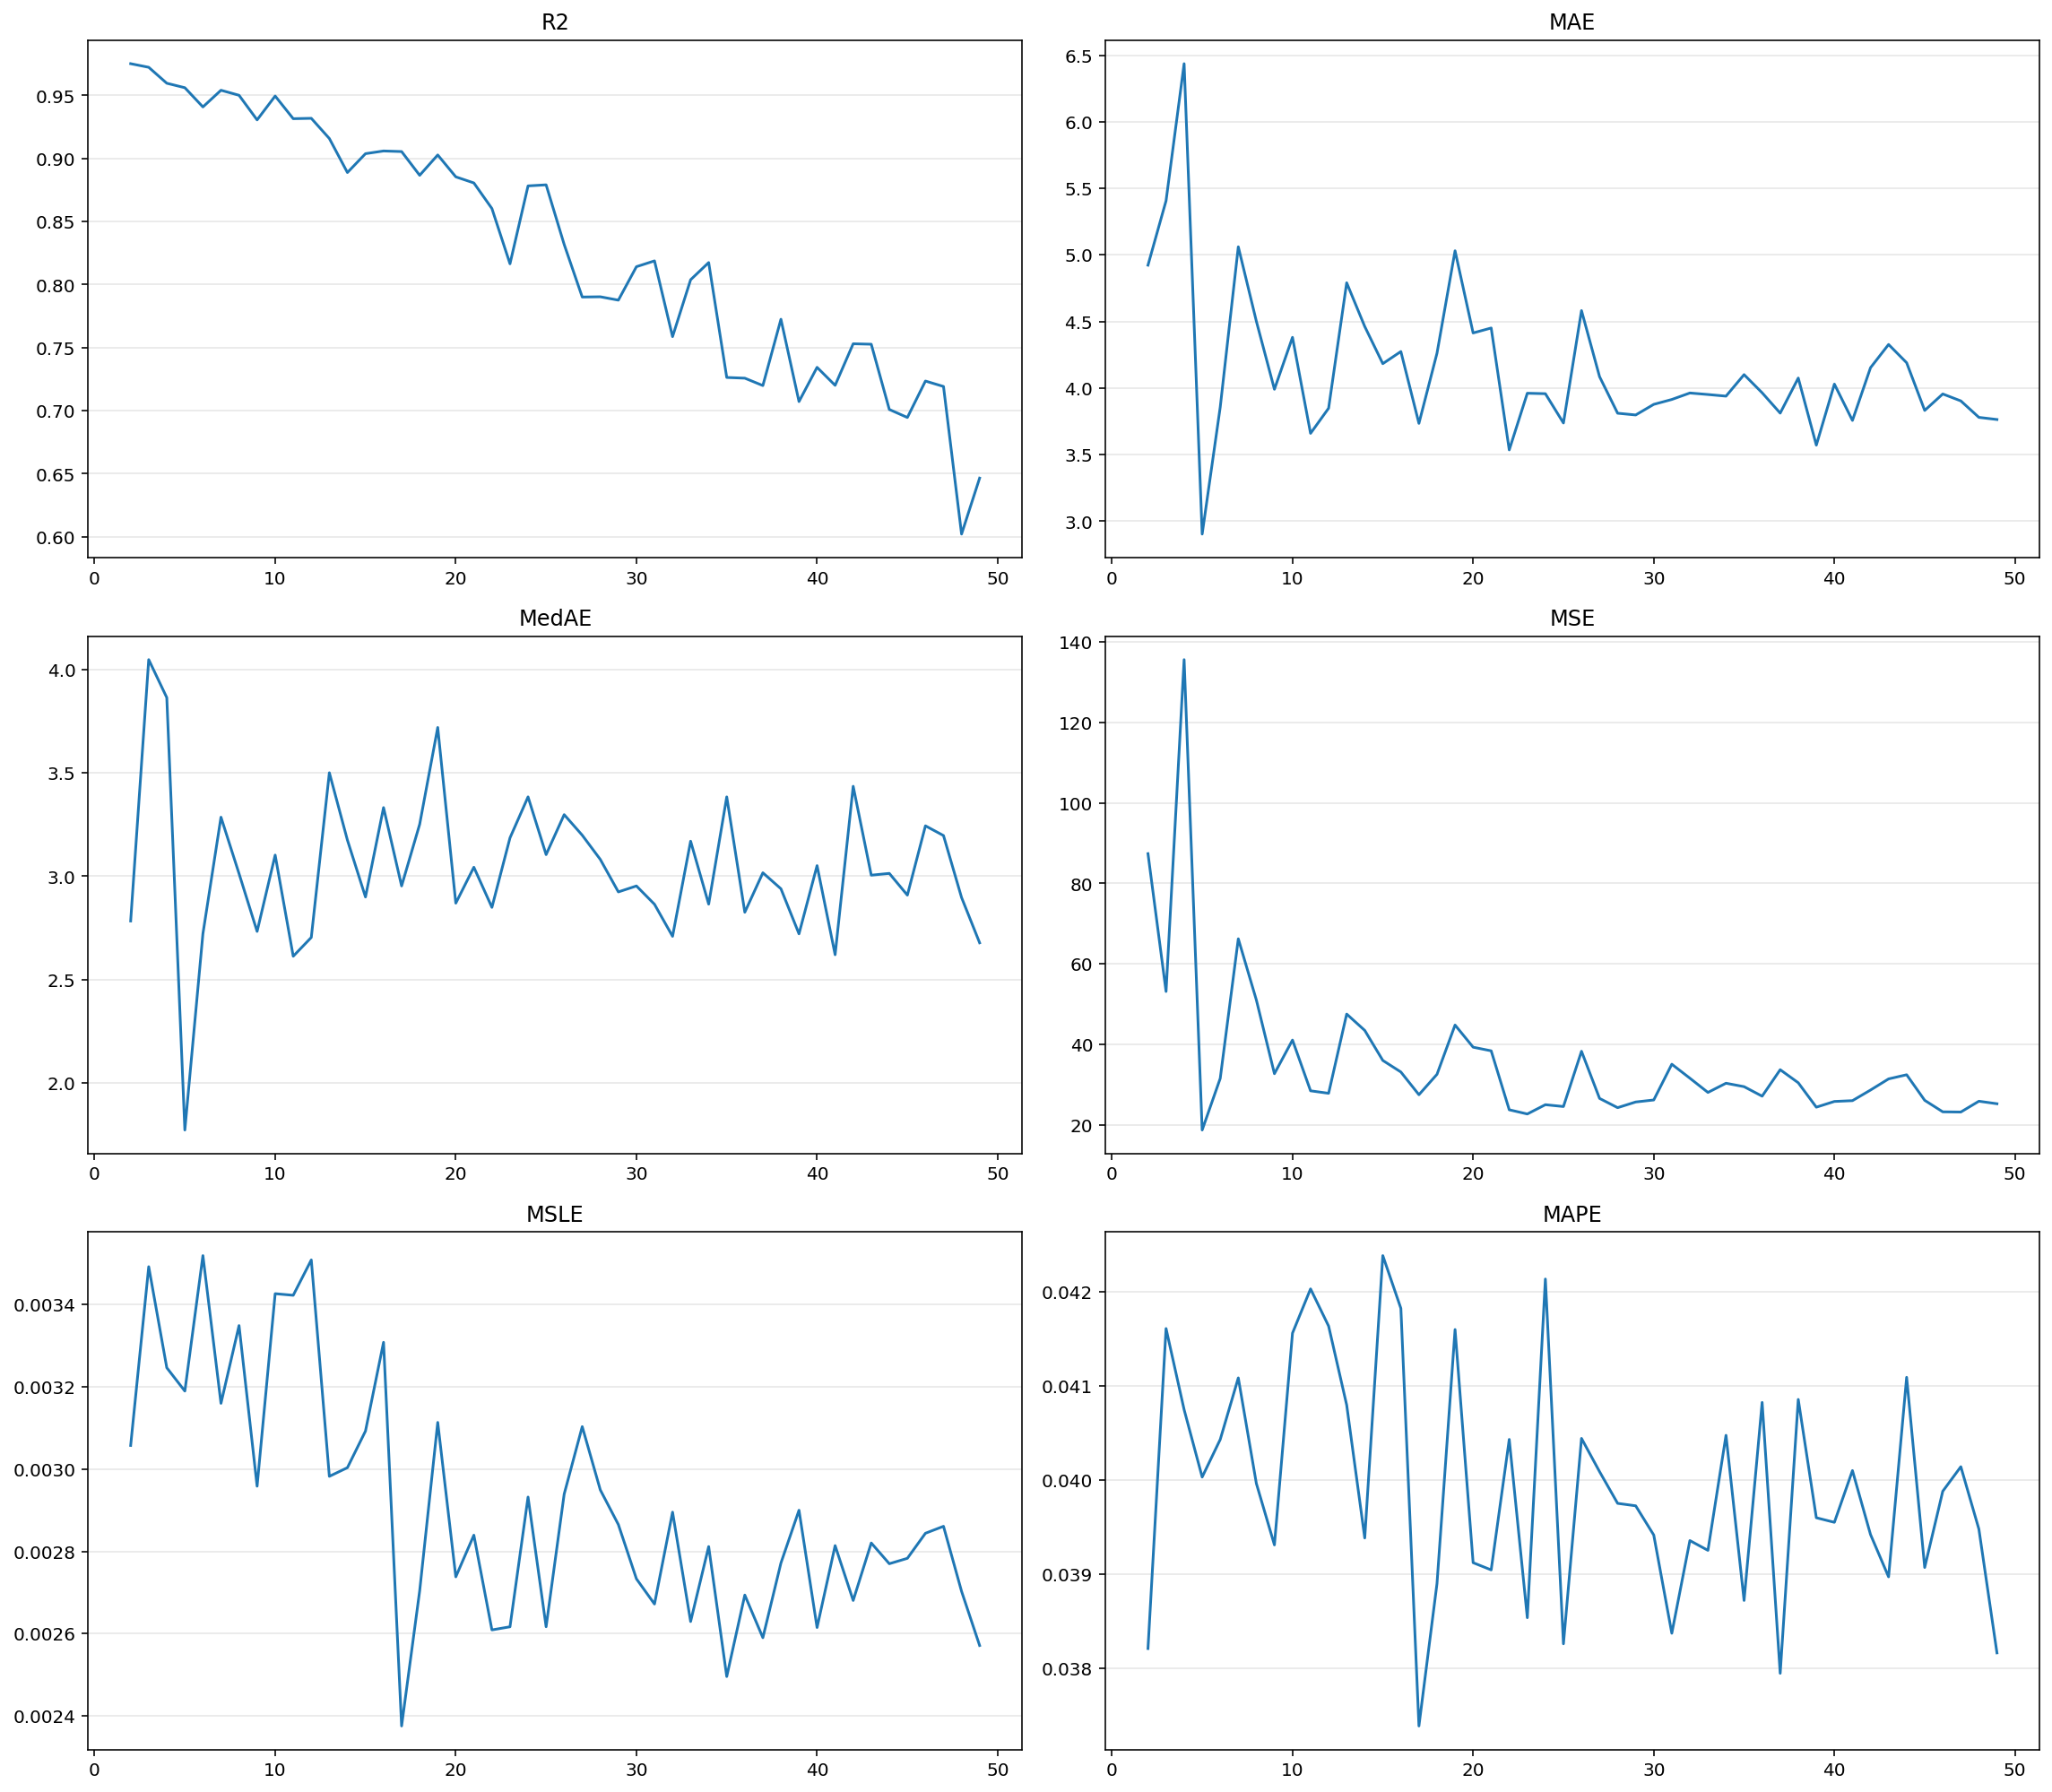

In [41]:
fig, ax = plt.subplots(3, 2, figsize=(16,14))
for i, col in enumerate(res2):
    ax[i//2, i%2].plot(res2[col])
    ax[i//2, i%2].set_title(col)
    ax[i//2, i%2].grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('freq_res1.png', bbox_inches='tight');

In [50]:
def solve3(df):
    lag_df = build_window(df, 5)
    X = lag_df.drop('close', axis=1)
    y = lag_df['close']
    res = [X.columns]
    tscv = TimeSeriesSplit(n_splits=15)

    for train, test in tscv.split(X):
        lasso = Lasso()
        scaler = StandardScaler()
        X_tr, X_te = X.values[train], X.values[test]
        y_tr, y_te = y.values[train], y.values[test]
        X_tr_scaled = scaler.fit_transform(X_tr)
        X_te_scaled = scaler.transform(X_te)

        lasso.fit(X_tr_scaled, y_tr)
        res.append(lasso.coef_)    
    
    return res

In [51]:
res3 = solve3(clear_df)

In [53]:
res_df3 = pd.DataFrame(res3[1:], columns=res3[0])

In [59]:
res_df3 = pd.DataFrame(np.abs(np.mean(res_df3)), columns=['Importance'])

In [67]:
res_df3.sort_values('Importance', ascending=False).head(9)

,Importance
close_lag1,65.660154
close_lag2,8.576087
close_lag5,1.527130
volume_em_lag3,1.267810
volume_vpt_lag5,0.182101
trend_adx_lag5,0.088455
volume_sma_em_lag3,0.071051
momentum_stoch_lag2,0.059963
volume_adi_lag2,0.033607


In [72]:
res_df3.sort_values('Importance', ascending=False).iloc[9:18, :]

,Importance
trades_lag2,0.028436
volume_obv_lag2,0.028032
close_lag3,0.025952
momentum_rsi_lag1,0.021171
volume_nvi_lag2,0.016820
trades_lag1,0.014955
volume_fi_lag5,0.007906
trend_dpo_lag3,0.004098
trend_aroon_down_lag2,0.000437
